<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/Tabular-Playground-Series---Jun-2021/blob/main/Tabular_Playground_Series_Jun_2021_%5Bacardara%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introuction/Load Data

Code entry for the **Tabular Playground Series - Jun 2021** kaggle competition.

https://www.kaggle.com/c/tabular-playground-series-jun-2021/overview



Inspiration for the code from the keras functional_api guide.

https://keras.io/guides/functional_api/.


In [1]:
# mount google drive to download dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [34]:
# create a folder to store dataset files
!mkdir /content/dataset
!mkdir /content/models

# copy dataset from google drive
!cp /content/gdrive/MyDrive/kaggle/train.csv /content/dataset
!cp /content/gdrive/MyDrive/kaggle/test.csv /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [4]:
import numpy as np

def shuffle_data(data):
  i = np.random.permutation(len(data))
  new_data = data[i]
  return new_data

# def shuffle_data_xyz(x, y, z):
#   i = np.random.permutation(len(x))
#   new_x = x[i]
#   new_y = y[i]
#   new_z = z[i]
#   return new_x, new_y, new_z

def split_train_val(dataset, split=0.8, shuffle=True):
  # shuffle rows in dataset
  if shuffle:
    dataset = shuffle_data(dataset)

  train_set_length = int(len(dataset) * split)

  # split dataset into real sets of 
  train_set = dataset[0:train_set_length]
  val_set = dataset[train_set_length:]
  return train_set, val_set

def labels_to_int(labels):
# applying to_categorical is currently causing an error, 
# TODO: implement it correctly
  new_labels = []
  for label in labels:
    # we want the 6th character of each class label string ie 'Class_7' should 
    # convert to '7'

    # to_categorical expects values to start from 0, dataset is in range [1,9]
    # we must subtract 1 from class labels for training to get the range [0,8]
    new_labels.append(int(label[-1])-1)
  new_labels = np.asarray(new_labels)
  # return to_categorical(new_labels, NUMBER_OF_CLASSES)
  return new_labels

def split_data(dataset, is_test=False):
  if not is_test:
    id = dataset[:,0]
    features = dataset[:,1:-1]
    label = dataset[:,-1]
    label = labels_to_int(label)
  else:
    id = dataset[:,0]
    features = dataset[:,1:]
    label = None
  return id, features, label

In [57]:
import pandas as pd

raw_dataset_train = pd.read_csv("/content/dataset/train.csv", header=0)
np_dataset_train = raw_dataset_train.to_numpy()
train, val = split_train_val(np_dataset_train)

print(train.shape)
print(val.shape)

# dataset_train = raw_dataset.to_numpy()[0:140_000]
# dataset_validation = raw_dataset.to_numpy()[140_000:]

# print(dataset_train.shape)
# print(dataset_validation.shape)

raw_testset = pd.read_csv("/content/dataset/test.csv", header=0)
np_testset = raw_testset.to_numpy()
test, _ = split_train_val(np_testset, split=1, shuffle=False)
print(test.shape)

(160000, 77)
(40000, 77)
(100000, 76)


### Training Loop

In [42]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

NUMBER_OF_CLASSES = 9
SUMMARIZE_AFTER = 1

def generate_training_samples(features, labels, n_samples):
  rows = np.random.permutation(features.shape[0])[0:n_samples]

  x = features[rows].astype("float32")
  y = labels[rows].astype("float32")

  return x, y

# print accuracy of holdout dataset
def summarize_performance(features, labels, model, epoch):
  train_x, train_y = generate_training_samples(features, labels, features.shape[0])
  _loss, _accuracy = model.evaluate(train_x, train_y)
  return _loss

def train_model(dataset_train, dataset_validation, model, n_epochs, batch_size, save_dir="/content/models/"):
  train_ids, train_features, train_labels = split_data(dataset_train)
  val_ids, val_features, val_labels = split_data(dataset_validation)

  iterations_per_epoch = dataset_train.shape[0]
  batches_per_epoch = iterations_per_epoch//batch_size
  for epoch in range(n_epochs):
    temp_train_loss = []

    for batch in range(batches_per_epoch):
        train_x, train_y = generate_training_samples(train_features, train_labels, batch_size)
        _loss, _accuracy = model.train_on_batch(train_x, train_y)
        temp_train_loss.append(_loss)

        if batch % 200 == 0:
          print(">%d %d/%d, %.3f, %.3f"%(epoch, batch, batches_per_epoch, _loss, _accuracy))

    # print metrics every epoch
    if (epoch + 1) % SUMMARIZE_AFTER == 0:
      train_loss.append(sum(temp_train_loss)/len(temp_train_loss))
      val_loss = summarize_performance(val_features, val_labels, model, epoch)
      validation_loss.append(val_loss)
      checkpoint_name = save_dir+str(epoch).zfill(4)+".h5"
      model.save(checkpoint_name)
      model_checkpoints.append(checkpoint_name)



### Models

In [52]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

def define_baseline_model():
  input_layer = Input(shape=(75,), name="First_Layer")

  output_layer = Dense(128, activation="relu")(input_layer)
  output_layer = Dropout(0.4)(output_layer)
  
  output_layer = Dense(64, activation="relu")(output_layer)
  output_layer = Dense(NUMBER_OF_CLASSES, activation="softmax")(output_layer)
  
  model = Model(inputs=input_layer, outputs=output_layer, name="Simple_Classification_Model")

  loss = SparseCategoricalCrossentropy()
  opt = Adam(learning_rate=0.0005, beta_1=0.8)
  model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
  return model

### Train Models

In [53]:
train_loss, validation_loss, model_checkpoints = [], [], []

n_epochs = 50
batch_size = 100

model = define_baseline_model()

model.summary()
train_model(train, val, model, n_epochs, batch_size)

Model: "Simple_Classification_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First_Layer (InputLayer)     [(None, 75)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               9728      
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_44 (Dense)             (None, 9)                 585       
Total params: 18,569
Trainable params: 18,569
Non-trainable params: 0
_________________________________________________________________
>0 0/1600, 5.497, 0.160
>0 200/1600, 2.269, 0.200
>0 400/1600, 2.110, 0.270
>0 600/1600, 2.125, 0.240

KeyboardInterrupt: ignored

### Visualize losses

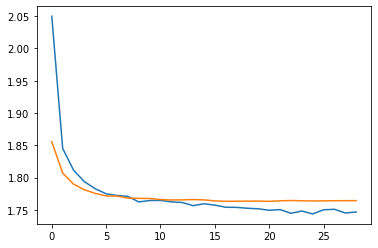

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [SUMMARIZE_AFTER*i for i in range(len(train_loss))]
plt.plot(x, train_loss)
plt.plot(x, validation_loss)
plt.show()

In [49]:
from tensorflow.keras.models import load_model

val_ids, val_features, val_labels = split_data(val)

for epoch, model_name in enumerate(model_checkpoints):
  temp_model = load_model(model_name)
  summarize_performance(val_features, val_labels, temp_model, epoch)

 543/1250 [============>.................] - ETA: 1s - loss: 1.7815 - accuracy: 0.3530

KeyboardInterrupt: ignored

### Run Test

In [62]:
import pandas as pd


def predict_class(model, features):
  features = np.expand_dims(features, axis=0)
  return model.predict(features)

def predict_testset(model, test_ids, test_features):
  labels = ["id","Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"]
  
  results = []
  # ids = testset[:,0]
  ids = test_ids.reshape((test_ids.shape[0]), 1)
  ids = pd.DataFrame(data=ids, columns=[labels[0]])

  # data = testset[:,1:]
  results = model.predict(test_features)
  results = pd.DataFrame(data=results, columns=labels[1:])

  final = pd.concat([ids, results], axis=1)
  # final = np.hstack((ids,results))

  # return pd.DataFrame(data=final, columns=labels)
  return final


test_model = load_model(model_checkpoints[20])
test_ids, test_features, _ = split_data(test, is_test=True)
results = predict_testset(model, test_ids, test_features)
results.to_csv("submission.csv", index=False)
# print(results)

### UMAP

In [ ]:
!pip install umap-learn
!pip install babyplots
!pip install hdbscan 

In [ ]:
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from babyplots import Babyplot
import hdbscan



dataset = raw_dataset.to_numpy()[:,1:-1]
labels = raw_dataset.to_numpy()[:,-1]

dataset = StandardScaler().fit_transform(dataset)

le = preprocessing.LabelEncoder()
class_names = ["Class_1", "Class_2", "Class_3", "Class_4", "Class_5", "Class_6", "Class_7", "Class_8", "Class_9"]
le.fit(class_names)
labels = le.transform(labels)

print(labels)
print(dataset)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.30)
reducer2d = umap.UMAP(n_neighbors=20,
                        min_dist=0.0,
                        n_components=2,
                        random_state=42, metric='euclidean', target_weight=0)

reducer3d = umap.UMAP(n_neighbors=20,
                      min_dist=0.0,
                      n_components=3,
                      random_state=42, metric='euclidean', target_weight=0)

# mapper2d = reducer2d.fit(X_train, y_train)
mapper3d = reducer3d.fit(X_train, y_train)

# embedding2d_train = mapper2d.transform(X_train)
embedding3d_train = mapper3d.transform(X_train)



# embedding2d_test = mapper2d.transform(X_test)
embedding3d_test = mapper3d.transform(X_test)

# embedding2d = embedding2d_train.tolist() + embedding2d_test.tolist()
embedding3d = embedding3d_train.tolist() + embedding3d_test.tolist()
# y_test 
print(y_test.shape)
# y_test = np.where(y_test >= 1, 'RI', 'DE')
y_plot = y_train.tolist() + y_test.tolist()
bp = Babyplot(background_color="#ffffddff", )
bp.add_plot(embedding3d, 'pointCloud', 'categories', y_plot, {
    'colorScale': 'Viridis',
    'showLegend': True,
    'folded': True,
    'size': 5,
    'showAxes': [True, True, True],
    'axisLabels': ['X', 'Y', 'Z'],
    'showTickLines': [[True, True], [True, True], [True, True]]
})
bp.save_as_html(r'/content/test3.html')


In [ ]:
import hdbscan
from sklearn.model_selection import train_test_split


dataset = raw_dataset.to_numpy()[:,1:-1]
labels = raw_dataset.to_numpy()[:,-1]

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.30)

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(X_train, y_train)